In [1]:
!pip3 install ezdxf

     |████████████████████████████████| 2.2MB 12.6MB/s 


In [2]:
import tensorflow as tf
import os
import glob
import numpy as np
import shutil

import random
import cv2
import matplotlib.pyplot as plt
import ezdxf 

ドライブを接続

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h1>モデルのロード Load Model
<br/>

モデルの保存先を更新してください 

In [53]:
MODEL_LOC="/content/drive/MyDrive/Colab Notebooks/AI/crack_model/models/UNET1_standard_20210702.h5"
MODEL_NAME=os.path.basename(MODEL_LOC).replace(".h5","")
model=tf.keras.models.load_model(MODEL_LOC)

# 画像処理の関数

In [22]:
#モデルの予想の画像は正規化から戻る
def prepare_output(image):
    image = image[:,:,0]
    image = np.clip(image, 0, 1)
    return np.multiply(image, 255)
#表示
def imshow_ccbar(image,cmap="gray",title=None):
  plt.figure()
  im=plt.imshow(image,cmap=cmap)
  plt.colorbar(im)
  if title:
    plt.title(title)
  plt.show()
  
#閾値
def threshold(image, min_limit=None, max_limit=256, clip=0):
    if min_limit is None:
        min_limit = int(np.mean(image) + clip)

    _, image = cv2.threshold(image, min_limit, max_limit, cv2.THRESH_BINARY)
    return image
#輪郭を抽出する
def predToContours(img_pred,img_original,thresh_mim=55,MIN_C=20,plot=False):
  #正規化から0-255の数へ変換する
  img_p1=prepare_output(img_pred)
  if plot:
    imshow_ccbar(img_p1,title="0-255")
  #平滑化 ぼかし
  img_p2 = cv2.GaussianBlur(img_p1,(3,3), 1)
  if plot:
    imshow_ccbar(img_p2,title="GaussianBlur")
  #閾値
  img_p3 = threshold(img_p2, min_limit=thresh_mim)
  if plot:
     imshow_ccbar(img_p3,title="threshhold")
  
  #輪郭の機能で扱いデータの形式 uint8へ変換する
  img_p3=cv2.convertScaleAbs(img_p3)
  #輪郭
  contours, hierarchy = cv2.findContours(img_p3,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  #小さいな輪郭を抜ける
  usecontours=[]
  
  for contour in contours:
    if len(contour)>=MIN_C:
      usecontours.append(contour)
  if plot:
    new_img=cv2.drawContours(img_original,usecontours,-1,color=(0,0,255),thickness=2)
    plt.figure()
    plt.imshow(new_img,cmap="gray")
    plt.title("Contours")
  return usecontours

#輪郭からdxfのファイルを変換する
def ContoursToDxf(contours,savename):
    #dxf file creation dxfのファイルを作成する
    dwg = ezdxf.new("R2010")
    msp = dwg.modelspace()
    #亀裂のレイヤーを作成
    dwg.layers.new(name="Crack",dxfattribs={"color":3})
    #Add contors to dxf dfxには輪郭を加える

    for ctr in contours:
        for i in range(len(ctr)):
            j= i+1
            if j>=len(ctr):
                j=0
            try:
                msp.add_line(ctr[i][0],ctr[j][0], dxfattribs={'layer':"Crack"})
            except Exception as e:
                print(ctr[i],'->',ctr[j])
                print(e.args)

    dwg.saveas(f'{savename}.dxf')

In [52]:
def fullImageContours(tiles,preds_tiles,locs,title,savedxf=True,plot=False,img_original=None):
  AllContours=[]
  P_tiles=[]
  N_tiles=[]
  for loc,tile,pred in zip(locs,tiles,preds_tiles):
      ##Modelの確認
      P_tiles.append(tile)
      ##輪郭を抽出する
      contours=predToContours(pred,tile,thresh_mim=10,MIN_C=20,plot=False)
      points=np.squeeze(contours).shape[0]
    # print(points)
      #if points<100:
      #結果はもともとの画像の表座に変換する
      for i in range(0,len(contours)):
          for j in range(0,len(contours[i])):
              contours[i][j]+=np.flip(loc)
          AllContours.append(contours[i])
  if savedxf:
      ContoursToDxf(AllContours,title)

  if plot:
    new_img=cv2.drawContours(img_original.copy(),AllContours,-1,color=(0,0,255),thickness=2)
    plt.figure(figsize=(6,6))
    plt.imshow(new_img,cmap="gray")
    plt.title(f"Contours \n {title}")

	zip warning: name not matched: ./content/drive/MyDrive/Colab_Notebooks/AI/crack_model

zip error: Nothing to do! (try: zip -r crack_model.zip . -i ./content/drive/MyDrive/Colab_Notebooks/AI/crack_model)


# 設定 Settings 

In [16]:
#訓練のデータのサイズ
IMG_HEIGHT=128
IMG_WIDTH=128
#グレースケール？
GRAY=True

# 画像をアップロード

In [59]:
from google.colab import files
uploaded = files.upload()

Saving D-009.jpg to D-009.jpg


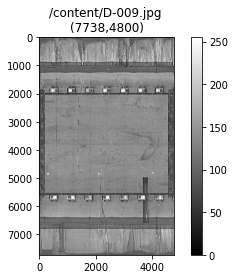

In [60]:
file="/content/"+list(uploaded.keys())[0]
if GRAY:
  img=cv2.imread(file,0)
  h,w=img.shape
  imshow_ccbar(img,title=f"{file} \n({h},{w})")
  
else:
  img=cv2.imread(file) 
  h,w,c=img.shape
  imshow_ccbar(file,cmap=None,title=f"{file} \n({h},{w})")

In [61]:
#Is a image split needed 
#画像を分けるが必要ですか？
lim=4
SPLIT=False
if (w//IMG_WIDTH>lim) or (h//IMG_HEIGHT>lim):
  print("Split set to true") 
  SPLIT=True

Split test recomened


In [62]:
if SPLIT:
  M=h//(h//IMG_HEIGHT)
  N=w//(w//IMG_WIDTH)
  #画像を分ける
  tiles = [cv2.resize(img[x:x+M,y:y+N],(IMG_HEIGHT,IMG_WIDTH)) for x in range(0,img.shape[0],M) for y in range(0,img.shape[1],N)]
  #分けるの部分の上左の点　表座
  locs=  [[x,y] for x in range(0,img.shape[0],M) for y in range(0,img.shape[1],N)]
  #予想
  tiles=np.array(tiles) 
  crack_preds=model.predict(tiles,verbose=2)

else:
  img=cv2.resize(img,(IMG_HEIGHT,IMG_WIDTH))
  img=img.reshape(128,128,1) 
  crack_preds=model.predict(np.array([img]),verbose=2)


73/73 - 69s


In [63]:
crack_preds.shape

(2318, 128, 128, 1)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


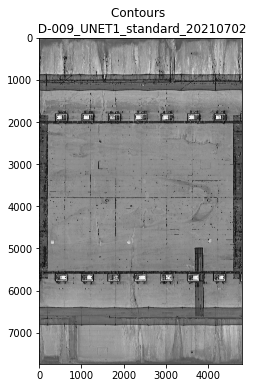

In [65]:
title=os.path.basename(file).replace(".jpg","_")+MODEL_NAME
if SPLIT: #分けった画像
  fullImageContours(tiles,crack_preds,locs,title,savedxf=True,plot=True,img_original=img.copy())

else: #一つの画像
  savedxf=True
  plot=True
  #輪郭を抽出する
  contours=predToContours(crack_preds[0],img.copy(),thresh_mim=10,MIN_C=20,plot=False)
  points=np.squeeze(contours).shape[0]
  if savedxf:
      ContoursToDxf(contours,title)
  if plot:
    new_img=cv2.drawContours(img.copy(),contours,-1,color=(0,0,255),thickness=2)
    plt.figure(figsize=(6,6))
    plt.imshow(np.squeeze(new_img),cmap="gray")
    plt.title(f"Contours \n {title}")